1. EDA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MeanShift, DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples

In [2]:
import zipfile
zipfile.ZipFile('C:\\Users\\Dongjun\\.kaggle\\retail.zip').extractall('C:\\Users\\Dongjun\\.kaggle\\retail') 
df=pd.read_csv('C:\\Users\\Dongjun\\.kaggle\\retail\\data.csv',encoding='unicode_escape') #Thanks stackoverflow!

1-1. Basic statistics

In [3]:
df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom


In [4]:
df.info() #2,6 null #0,1(get rid of first,last letter),2(last word),4(datetime),5(qcut binning),7(get dummies)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
df.Quantity.value_counts(sort=True)

 1       148227
 2        81829
 12       61063
 6        40868
 4        38484
          ...  
-1681         1
-657          1
 199          1
-313          1
 512          1
Name: Quantity, Length: 722, dtype: int64

In [6]:
df=df[df.Quantity>0] #flawed data

1-2. Basic feature engineering

In [7]:
df['Money']=df.Quantity*df.UnitPrice

In [8]:
df.groupby(['InvoiceNo','StockCode'])['InvoiceNo'].count() #grouping by 2features create special dataframe #need RFM set of key values

InvoiceNo  StockCode
536365     21730        1
           22752        1
           71053        1
           84029E       1
           84029G       1
                       ..
581587     23255        1
           23256        1
A563185    B            1
A563186    B            1
A563187    B            1
Name: InvoiceNo, Length: 520750, dtype: int64

In [9]:
df.InvoiceDate.astype(str) #only str data can become datetime
df['InvoiceDate']=pd.to_datetime(df['InvoiceDate'],format='%m/%d/%Y %H:%M')

1-3. Encoding

2. Preprocessing

2-1. Imputation

In [10]:
df=df[df.CustomerID.notnull()]

2-2. Discretization

In [11]:
df.Country.value_counts(sort=True)

United Kingdom          354345
Germany                   9042
France                    8342
EIRE                      7238
Spain                     2485
Netherlands               2363
Belgium                   2031
Switzerland               1842
Portugal                  1462
Australia                 1185
Norway                    1072
Italy                      758
Channel Islands            748
Finland                    685
Cyprus                     614
Sweden                     451
Austria                    398
Denmark                    380
Poland                     330
Japan                      321
Israel                     248
Unspecified                244
Singapore                  222
Iceland                    182
USA                        179
Canada                     151
Greece                     145
Malta                      112
United Arab Emirates        68
European Community          60
RSA                         58
Lebanon                     45
Lithuani

In [12]:
df.loc[(df.Country=='United Kingdom'),'UK']=1 #I wasn't wrong in santander(disproportinate dataset can be regarded as binary)
df.loc[(df.Country!='United Kingdom'),'UK']=0
df.drop('Country',axis=1,inplace=True)

2-3. Feature selection

In [13]:
df.groupby('CustomerID')['Money'].sum().sort_values(ascending=False) #grouping by one feature creates dataframe #then sort series

CustomerID
14646.0    280206.02
18102.0    259657.30
17450.0    194550.79
16446.0    168472.50
14911.0    143825.06
             ...    
17956.0        12.75
16454.0         6.90
14792.0         6.20
16738.0         3.75
13256.0         0.00
Name: Money, Length: 4339, dtype: float64

In [14]:
cust_df=df.groupby('CustomerID').agg({'InvoiceDate':'max','InvoiceNo':'count','Money':'sum'}) #groupby creates indices #need aggregation for each person(new dataframe)
cust_df=cust_df.rename(columns={'InvoiceDate':'Recency','InvoiceNo':'Frequency'}) #columns= is essential
cust_df

,Recency,Frequency,Money
CustomerID,,,
12346.0,2011-01-18 10:01:00,1,77183.60
12347.0,2011-12-07 15:52:00,182,4310.00
12348.0,2011-09-25 13:13:00,31,1797.24
12349.0,2011-11-21 09:51:00,73,1757.55
12350.0,2011-02-02 16:01:00,17,334.40
...,...,...,...
18280.0,2011-03-07 09:52:00,10,180.60
18281.0,2011-06-12 10:53:00,7,80.82
18282.0,2011-12-02 11:43:00,12,178.05


In [15]:
cust_df['Recency']=cust_df.Recency.max()-cust_df['Recency']
cust_df['Recency']=cust_df['Recency'].apply(lambda x: x.days+1)
cust_df

,Recency,Frequency,Money
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,19,73,1757.55
12350.0,310,17,334.40
...,...,...,...
18280.0,278,10,180.60
18281.0,181,7,80.82
18282.0,8,12,178.05


In [16]:
scaled=np.log1p(cust_df) #StandardScaler did nothing
scaled_df=pd.DataFrame(scaled,columns=['Recency','Frequency','Money'])

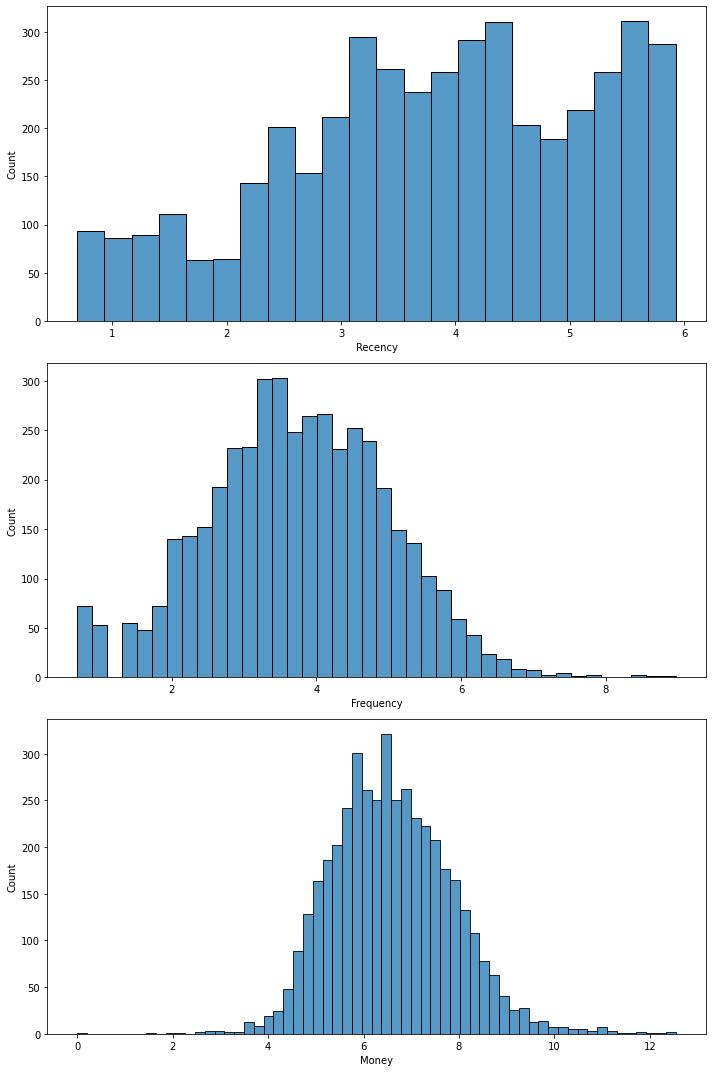

In [17]:
fig=plt.figure(figsize=(10,15)) #constrained_layout is still in progress(3.2.2)
fig.add_subplot(311)
sns.histplot(data=scaled_df,x='Recency') #from sns use countplot and histplot
fig.add_subplot(312)
sns.histplot(data=scaled_df,x='Frequency')
fig.add_subplot(313)
sns.histplot(data=scaled_df,x='Money')
fig.tight_layout() #At very last
plt.show()

3. Modeling

In [18]:
pca_transformed=PCA(n_components=2).fit_transform(scaled_df)
scaled_df['x']=pca_transformed[:,0] #indexing column need information about rows
scaled_df['y']=pca_transformed[:,1]

In [19]:
scaled_df['Label']=pd.Series(dtype=int)
scaled_df['Score']=pd.Series(dtype=float)
feature_df=scaled_df[['Recency','Frequency','Money']] #clustering too need feature_df

For 2 clusters the average silhouette_score is 0.3980245098737219


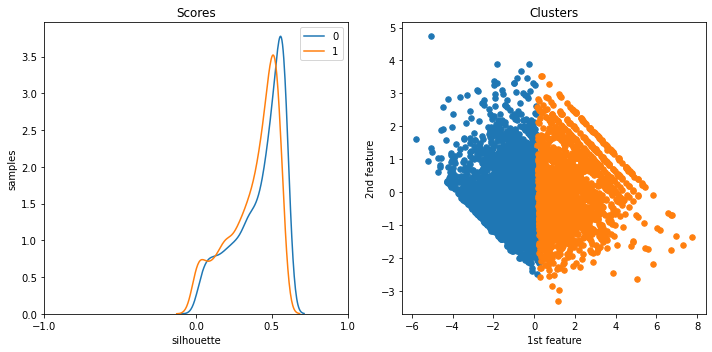

For 3 clusters the average silhouette_score is 0.3034842644680556


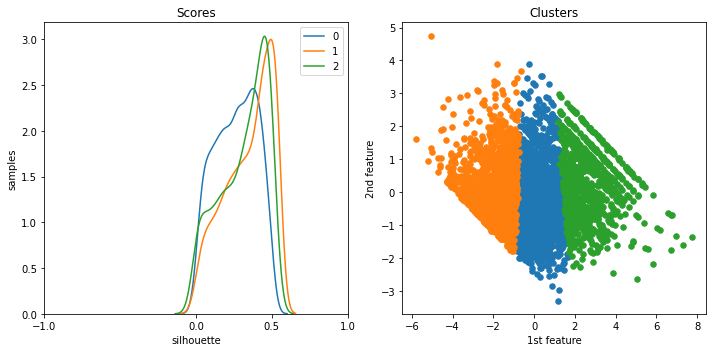

For 4 clusters the average silhouette_score is 0.310843669385941


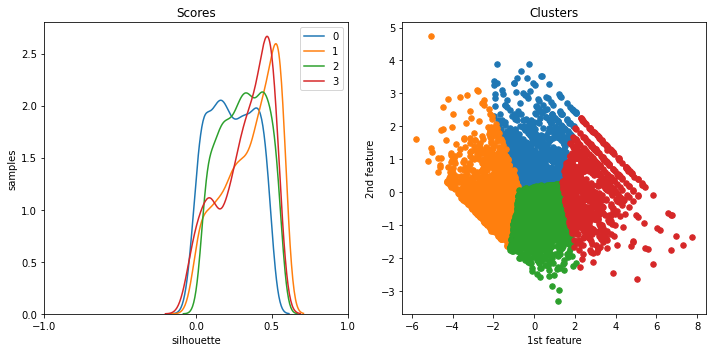

For 5 clusters the average silhouette_score is 0.2762496140108925


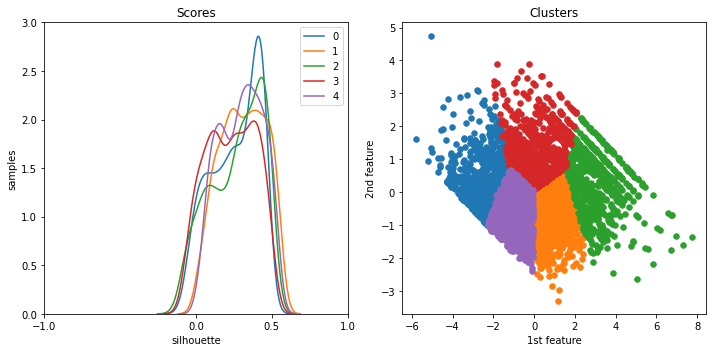

In [20]:
n_clusters = [2, 3, 4, 5]
for n in n_clusters:
  fig=plt.figure(figsize=(10,5))
  kmeans=KMeans(n_clusters=n, random_state=0)
  label=kmeans.fit_predict(feature_df) #clustering always produces ndarray
  scaled_df['Label']=pd.Series(label,index=scaled_df.index) #making a series out of ndarray could be troublesome due to indice(took me an hour to debug)
  print(f'For {n} clusters the average silhouette_score is {silhouette_score(feature_df,scaled_df.Label)}')
  score=silhouette_samples(feature_df,scaled_df.Label)
  scaled_df['Score']=pd.Series(score,index=scaled_df.index)
  fig.add_subplot(121)
  cluster=pd.Series(dtype=int)
  for i in range(n):
     cluster=scaled_df.Score[scaled_df.Label==i] #actual labels are integers
     cluster.sort_values()
     sns.kdeplot(cluster,label=i) #histplot and kdeplot(displot not ready yet)
     plt.legend(loc='best')
  plt.title('Scores')
  plt.xlabel("silhouette")
  plt.ylabel("samples")
  plt.xticks([-1,0,0.5,1])
  
  fig.add_subplot(122)
  for i in range(n):
    sample=scaled_df[scaled_df.Label==i]
    plt.scatter(sample['x'], sample['y'], s=30)
  plt.title("Clusters")
  plt.xlabel("1st feature")
  plt.ylabel("2nd feature")
  fig.tight_layout()
  plt.show()